In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import math
import os, sys
sys.path.append(os.path.relpath("./src"))
from kitaev_chain import kitaev_chain_model, quench_simulation
FFwriter=FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
from utils import to_n, s0, sx, sy, sz, maj_ordered, tensor_product, canon_eigen, expm, U, c, zero, LOSCHMIDT_BDG, LOSCHMIDT_TFIM, STATES

## Simulation animation with loschmidt

In [14]:
n = 8
eigenvalue_index = range(n)
k = 4e-2

mu = np.zeros(n) + k
mu[0] = mu[-1] = 1e1
H0 = kitaev_chain_model(n, k, 1 - k, 1 - k)
H = kitaev_chain_model(n, mu, 1 - k, 1 - k)
sim = quench_simulation(H0, H)

U, V numerical incompabillity


In [24]:
sim.fill_sim(0.02, 5)

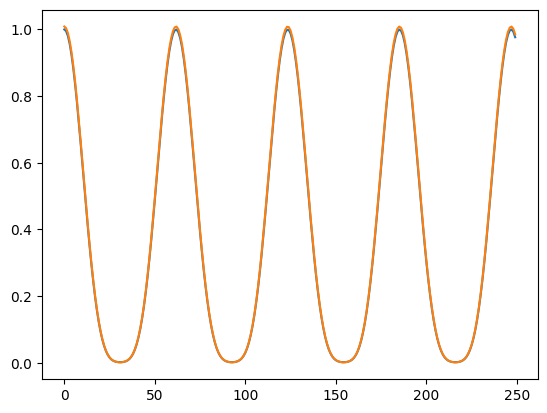

In [25]:
plt.plot(sim.simulation_data[LOSCHMIDT_BDG])
plt.plot(sim.simulation_data[LOSCHMIDT_TFIM] ** (2.0 / (n - 2)))

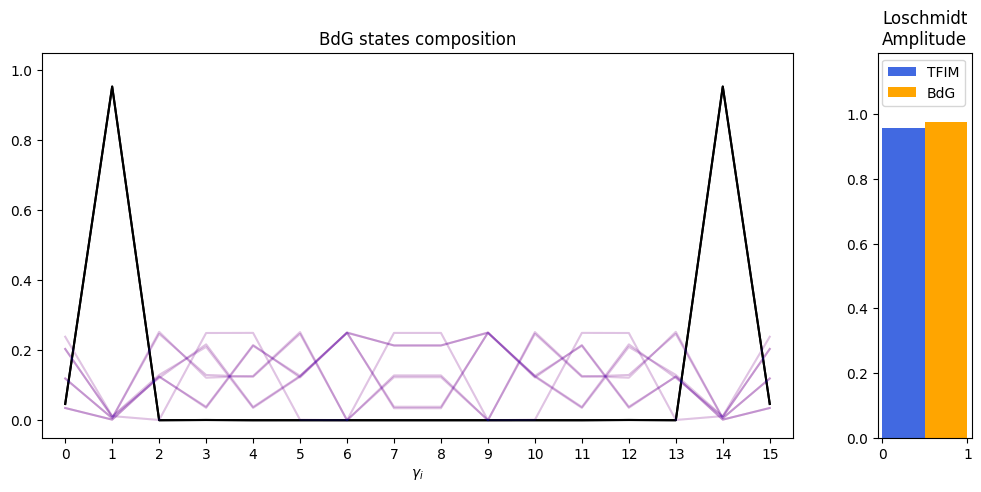

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [8, 1]})
fig.set_size_inches((12, 5))
plots = [None for _ in range(2 * n)]

ax1.set_title("BdG states composition")
ax1.set_xlabel("$\\gamma_{i}$")
ax1.set_xlim(-.5, 2 * n - .5)
ax1.set_xticks(range(2 * n))

ax2.set_title("Loschmidt\nAmplitude")
ax2.set_ylim(0,1.19)


for i, (energy, state) in enumerate(filter(lambda pair: True, zip(sim.H0.bdg_evals_sorted, sim.simulation_data[STATES][0].T))):
    plots[i] = ax1.plot(range(2 * n), np.absolute(maj_ordered(state)) ** 2, color=(1 if energy > 1e-4 else 0, 0, 1 if energy < -1e-4 else 0, math.exp(-(energy * 1.5) ** 2)), label={f"{i} - {energy:.3f}"})[0]
l_tfim = ax2.bar(0.25, sim.simulation_data[LOSCHMIDT_TFIM][0], 0.5, label='TFIM', color='royalblue')
l_bdg = ax2.bar(0.75, sim.simulation_data[LOSCHMIDT_BDG][0], 0.5, label='BdG', color='orange')
ax2.legend()

def init(): return *plots, *l_tfim.patches, *l_bdg.patches

def animate(frame):
    for i in range(2 * n):
        plots[i].set_data(range(2 * n), np.absolute(maj_ordered(sim.simulation_data[STATES][frame][:, i]) ** 2))
    l_tfim.patches[0].set_height(sim.simulation_data[LOSCHMIDT_TFIM][frame])
    l_bdg.patches[0].set_height(sim.simulation_data[LOSCHMIDT_BDG][frame])
    return *plots, *l_tfim.patches, *l_bdg.patches

anim = FuncAnimation(fig, animate,
                frames = len(sim.simulation_data[LOSCHMIDT_TFIM]), interval = 30, blit = True)

anim.save(f"simulations/quench.mp4", writer=FFwriter)

## Implementing the ghost sites method from this [article](https://arxiv.org/abs/2003.00095) 

In [3]:
def fermion_chain_from_spin_chain_params(n_sites, J, h_z, h_edges_x):
    n = n_sites + 2
    mu = np.ones(n) * h_z; mu[0] = mu[-1] = 0
    t = np.ones(n - 1) * J; t[0] = t[-1] = h_edges_x
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, True)

In [12]:
n_sites = 4
n = n_sites + 2
k = 1e-1
H0 = fermion_chain_from_spin_chain_params(n_sites, 1, 1, 200)
H = fermion_chain_from_spin_chain_params(n_sites, 1, 1, 1)
sim = quench_simulation(H0, H, hasGhosts=True)

Eigenvectors numerical incompabillity
U, V numerical incompabillity


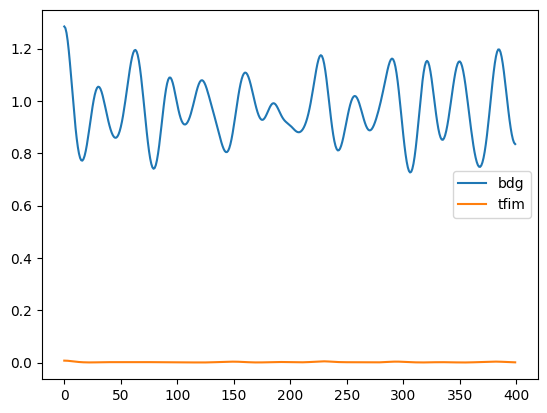

In [13]:
sim.fill_sim(.2, 80)
plt.plot(sim.simulation_data[LOSCHMIDT_BDG], label="bdg")
plt.plot(sim.simulation_data[LOSCHMIDT_TFIM] ** (2.0 / (n - 2)), label="tfim")
plt.legend()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [8, 1]})
fig.set_size_inches((12, 5))
plots = [None for _ in range(2 * n)]

ax1.set_title("BdG states composition")
ax1.set_xlabel("$\\gamma_{i}$")
ax1.set_xlim(-.5, 2 * n - .5)
ax1.set_xticks(range(2 * n))

ax2.set_title("Loschmidt\nAmplitude")
ax2.set_ylim(0,1.19)


for i, (energy, state) in enumerate(filter(lambda pair: True, zip(sim.H0.bdg_evals_sorted, sim.simulation_data[STATES][0].T))):
    plots[i] = ax1.plot(range(2 * n), np.absolute(maj_ordered(state)) ** 2, color=(1 if energy > 1e-4 else 0, 0, 1 if energy < -1e-4 else 0, math.exp(-(energy * 1.5) ** 2)), label={f"{i} - {energy:.3f}"})[0]
l_tfim = ax2.bar(0.25, sim.simulation_data[LOSCHMIDT_TFIM][0], 0.5, label='TFIM')
l_bdg = ax2.bar(0.75, sim.simulation_data[LOSCHMIDT_BDG][0], 0.5, label='BdG')
ax2.legend()

def init(): return *plots, *l_tfim.patches, *l_bdg.patches

def animate(frame):
    for i in range(2 * n):
        plots[i].set_data(range(2 * n), np.absolute(maj_ordered(sim.simulation_data[STATES][frame][:, i]) ** 2))
    l_tfim.patches[0].set_height(sim.simulation_data[LOSCHMIDT_TFIM][frame])
    l_bdg.patches[0].set_height(sim.simulation_data[LOSCHMIDT_BDG][frame])
    return *plots, *l_tfim.patches, *l_bdg.patches

anim = FuncAnimation(fig, animate,
                frames = len(sim.simulation_data[LOSCHMIDT_TFIM]), interval = 30, blit = True)

anim.save(f"simulations/quench.mp4", writer=FFwriter)